In [1]:
import numpy as np
import networkx as nx
import torch
import time
from sklearn.preprocessing import OneHotEncoder
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt

In this part, we focus on a simple road map (rep as a graph below), and generate random path on it.
<img src="img/naive_road.png" alt="Drawing" style="width: 400px;"/>

In [2]:
def one_hot(x, N = 24):
    l = np.zeros(24)
    l[x] = 1
    return l
def inv_one_hot(l, N = 24):
    return np.argmax(l)

In [3]:
def build_graph():
    G=nx.Graph()
    G.add_nodes_from(range(24))
    G.add_edges_from([(i, i+1) for i in range(5)] 
                     + [(i+6, i+7) for i in range(5)] 
                     +[(i+12, i+13) for i in range(5)]
                     + [(i+18, i+19) for i in range(5)]
                     + [(0,6),(6,12), (12,18)]
                     + [(pair[0]+1, pair[1]+1) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+2, pair[1]+2) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+3, pair[1]+3) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+4, pair[1]+4) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+5, pair[1]+5) for pair in [(0,6),(6,12), (12,18)]]
                     )
    return G

In [4]:
# gloable env
G = build_graph() 
N = len(G.node)

In [6]:
def random_path(start = None, stop_prob = 0.1):
    """
    Generate (hist dependent) random path on graph G with lenght at least 2, encode each road in one-hot fashion
    """
    if not start:
        start = np.random.choice(24)
    path = [start]
    prev = None
    while True:
        neighbors = list(G.neighbors(start))
        if prev:
            neighbors.remove(prev)
        nxt = np.random.choice(neighbors)
        path.append(nxt)
        prev = start
        start = nxt
        if np.random.rand() < stop_prob:
            break
    return np.array(path)

In [7]:
p = random_path()
print(p)

[0 6 0 1 2 3]


In [8]:
def random_training_set():
    def f(x):
        if x == -1:
            return 0
        if x == -6:
            return 1
        if x == 1:
            return 2
        if x == 6:
            return 3
    path = random_path()
    inp = torch.from_numpy(np.float32(np.array([one_hot(p) for p in path[:-1]])))
    #import pdb; pdb.set_trace()
    tar = [f(x) for x in path[1:] - path[:-1]]
    tar = torch.from_numpy(np.array(tar))
    return Variable(inp).contiguous(), Variable(tar).contiguous()

In [75]:
x,y = random_training_set()
print('x: {} is the sequence of road'.format([inv_one_hot(r) for r in x.data.numpy()]))
print('y: {} denotes the turning decistion at each road'.format(y.data.numpy()))

x: [21, 15, 14, 8, 9, 10, 11, 5, 4, 3, 9, 8, 14, 15, 21, 20, 19] is the sequence of road
y: [1 0 1 2 2 2 1 0 0 3 0 3 2 3 0 0 1] denotes the turning decistion at each road


In [10]:
x.size()

torch.Size([3, 24])

Since we know the road transition are markov (turing decision only depends on current road), let start with *none-recurrent nn* to fit our transition

In [90]:
N_batch, D_in, D_hidden, D_out = 50, 24, 100, 4
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(D_hidden, D_out),
    torch.nn.Softmax(dim = 1),
)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L = 0
n = 0
pts = {'x':[], 'y':[]}
for t in range(40000):
    x,y = random_training_set()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    L += sum(loss.data.numpy())
    n += len(loss.data.numpy())
    if t%1000 == 0:
        pts['x'].append(t)
        pts['y'].append(L/n)
        print(t, L/n)
        L = 0
        n = 0
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 1.38199687004
1000 1.34473011744
2000 1.33546652389
3000 1.32907759982
4000 1.3300471223
5000 1.32706870031
6000 1.32754559124
7000 1.32706234384
8000 1.32643003994
9000 1.32789237195
10000 1.32457457131
11000 1.32439737165
12000 1.32642408127
13000 1.32500540859
14000 1.32431879336
15000 1.32255000317
16000 1.32499148512
17000 1.32206426746
18000 1.32000809616
19000 1.32279704076
20000 1.3239448579
21000 1.32507582611
22000 1.32032233912
23000 1.32189218646
24000 1.32681311917
25000 1.32190672201
26000 1.32372510117
27000 1.32298129278
28000 1.3231674248
29000 1.32179115367
30000 1.32208962166
31000 1.31854408705
32000 1.32392090499
33000 1.32397338843
34000 1.32184692043
35000 1.32490998781
36000 1.32292026985
37000 1.32186268914
38000 1.32240355277
39000 1.32172858155


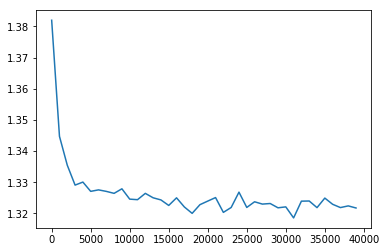

In [91]:
plt.plot(pts['x'],pts['y'])

In [92]:
x,y = random_training_set()
print([inv_one_hot(r) for r in x.data.numpy()])
model(x)

[8, 2, 3, 4, 10, 11, 17, 16, 22, 21, 15, 16, 17, 23, 22, 21]


Variable containing:
 2.5987e-01  2.5838e-01  2.5531e-01  2.2644e-01
 3.8750e-01  4.7785e-06  3.2027e-01  2.9222e-01
 4.2540e-01  9.8707e-09  2.7870e-01  2.9590e-01
 3.8976e-01  6.7869e-06  3.1812e-01  2.9211e-01
 2.5987e-01  2.5838e-01  2.5531e-01  2.2644e-01
 3.5742e-01  3.7158e-01  2.4004e-09  2.7100e-01
 3.2515e-01  3.9395e-01  6.0328e-06  2.8089e-01
 2.5987e-01  2.5838e-01  2.5531e-01  2.2644e-01
 3.2250e-01  3.4839e-01  3.2911e-01  1.4151e-07
 2.9624e-01  3.2365e-01  3.8012e-01  5.3860e-08
 2.5987e-01  2.5838e-01  2.5531e-01  2.2644e-01
 2.5987e-01  2.5838e-01  2.5531e-01  2.2644e-01
 3.2515e-01  3.9395e-01  6.0328e-06  2.8089e-01
 5.3123e-01  4.6867e-01  3.4848e-05  6.8151e-05
 3.2250e-01  3.4839e-01  3.2911e-01  1.4151e-07
 2.9624e-01  3.2365e-01  3.8012e-01  5.3860e-08
[torch.FloatTensor of size 16x4]

Clearly, the naive nn is not enough.
# RNN for Tracking the History

In [93]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.lin = nn.Linear(hidden_size, output_size)
        self.sm = nn.Softmax(dim = 2)
        
        hidden0 = torch.zeros(n_layers, 1, hidden_size)
        self.hidden0 = nn.Parameter(hidden0, requires_grad=True)
    
    def forward(self, inp, hidden):
        output, hidden = self.gru(inp.view(1, 1, self.input_size), hidden)
        output = self.lin(output) 
        output = self.sm(output)
        return output, hidden
    
    def init_hidden(self):
        return self.hidden0
    #def init_hidden(self):
    #    return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [95]:
def train(inp, target):
    hidden = rnn.init_hidden() 
    rnn.zero_grad()
    hat = []
    for i in range(len(inp)):
        output, hidden = rnn(inp[i,:], hidden)
        hat.append(output.view(-1,4))
    pred = torch.cat(hat)
    loss = loss_fn(pred, target)
    rnn_optimizer.zero_grad()
    loss.backward()
    rnn_optimizer.step()
    return pred, loss.data[0]

In [ ]:
N_batch, D_in, D_hidden, D_out = 50, 24, 200, 4
rnn = RNN(D_in, D_hidden, D_out, n_layers = 1)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.0002
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
L = 0
pts = {'x':[], 'y':[]}
for t in range(1,400001):
    x,y = random_training_set()
    _, loss = train(x,y)
    
    L += loss
    if t%10000 == 0:
        pts['x'].append(t)
        pts['y'].append(L/10000)
        print(t, L/10000)
        L = 0

10000 1.286796221756935
20000 1.250342443561554
30000 1.2468998183310032
40000 1.2425524953424931


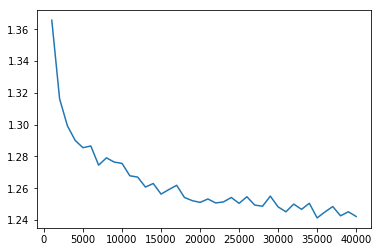

In [97]:
plt.plot(pts['x'],pts['y'])

In [98]:
x,y = random_training_set()
pred,_ = train(x,y)
print([inv_one_hot(r) for r in x.data.numpy()])
print(pred)

[22, 16, 17, 23, 22, 16, 17, 11, 10, 9, 15, 16, 10, 4, 3, 2, 1, 7, 6, 0, 1, 0, 6, 12, 13, 19, 18, 12, 6, 7, 8, 14, 15, 16, 22, 23, 17, 11]
Variable containing:
 2.1104e-01  9.0629e-02  6.9567e-01  2.6628e-03
 1.0383e-01  4.2233e-01  4.5087e-01  2.2968e-02
 8.2987e-02  5.0665e-01  2.8708e-03  4.0749e-01
 9.8604e-01  1.3808e-02  2.8462e-05  1.2014e-04
 7.1212e-01  2.8621e-01  1.5340e-03  1.4206e-04
 5.1818e-01  4.0311e-01  5.3838e-02  2.4874e-02
 8.6271e-02  4.2569e-01  1.5410e-03  4.8650e-01
 5.2202e-01  3.9715e-01  4.2323e-04  8.0402e-02
 6.8441e-01  2.9236e-01  9.1618e-03  1.4060e-02
 6.6718e-01  2.4017e-01  2.6994e-02  6.5654e-02
 3.7689e-01  2.2492e-02  4.4010e-02  5.5661e-01
 9.0795e-02  6.2107e-03  1.4983e-01  7.5316e-01
 1.0358e-01  2.6989e-01  5.5247e-01  7.4064e-02
 7.6741e-01  4.4550e-03  2.1561e-01  1.2524e-02
 1.4138e-01  1.0053e-04  9.1181e-03  8.4940e-01
 6.1608e-01  2.5379e-04  4.0352e-02  3.4332e-01
 5.6980e-01  2.7443e-04  3.6375e-02  3.9355e-01
 4.8969e-01  2.6103e-02 

In [ ]:
n_epochs = 1000
print_every = 100
#plot_every = 10
input_size = 24 # one hot encoding for 24 node in the graph
hidden_size = 200
output_size = 4 #?? distriubtuion for 4 exits??
n_layers = 2
lr = 0.005

rnn = RNN(input_size, hidden_size, output_size, n_layers)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / n_epochs * 100, loss))

In [ ]:
def generate(start):
    hidden = rnn.init_hidden()
    inp = start
    predicted = inp.data.view(1,2)
    
    for i in range(1, 1000):
        output, hidden = rnn(inp, hidden)
        predicted = torch.cat([predicted, output.data.view(1,2)])
        inp = output
    return predicted

In [ ]:
x,y = random_training_set()

In [ ]:
hidden = rnn.init_hidden()
o,h = rnn(x[0], hidden)
print(o)

In [ ]:
from sklearn.